Muss noch vertexten. 
Dieses Notebook verwendet die Daten aus DATASET. 

In [14]:
import os
import glob
import cv2 as cv
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib


--- Classification Report (Unweighted) ---
              precision    recall  f1-score   support

      defect       0.99      1.00      0.99       692
          ok       0.99      0.96      0.98       169

    accuracy                           0.99       861
   macro avg       0.99      0.98      0.99       861
weighted avg       0.99      0.99      0.99       861



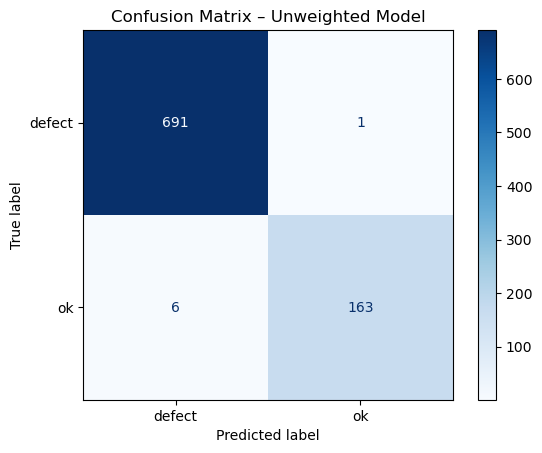


--- Classification Report (Weighted) ---
              precision    recall  f1-score   support

      defect       1.00      1.00      1.00       692
          ok       1.00      0.98      0.99       169

    accuracy                           1.00       861
   macro avg       1.00      0.99      0.99       861
weighted avg       1.00      1.00      1.00       861



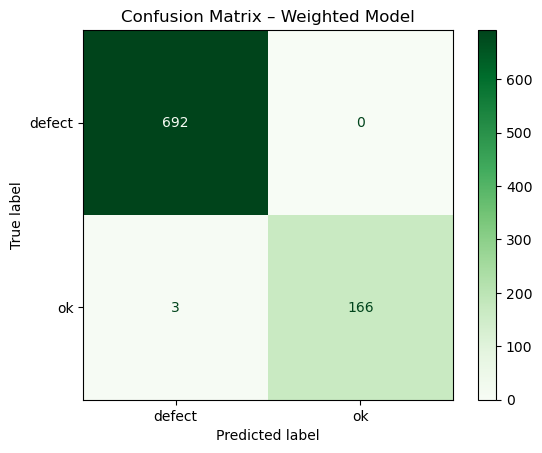


Weighted model saved as syringe_model_dataset_weighted.pkl


In [15]:
# train_syringe_modelAH_RF.ipynb




# --- Paths ---
base_path = "dataset"
ok_folder = "ok"
defect_folders = ["1_leer", "5_ObjektInSpritze", "6_kleineBlase", "7_grosseBlase", "8_Stoerung"]

# --- Feature extraction ---
def extract_features(image_path):
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv.resize(img, (64, 64))
    blur = cv.GaussianBlur(img, (5, 5), 0)
    edges = cv.Canny(blur, 30, 100)
    hist = cv.calcHist([img], [0], None, [16], [0, 256]).flatten()
    return np.concatenate([edges.flatten(), hist])

# --- Load images ---
features = []
labels = []

ok_path = os.path.join(base_path, ok_folder)
for filepath in glob.glob(os.path.join(ok_path, "*.jpg")):
    f = extract_features(filepath)
    if f is not None:
        features.append(f)
        labels.append("ok")

for defect_subfolder in defect_folders:
    defect_path = os.path.join(base_path, defect_subfolder)
    for filepath in glob.glob(os.path.join(defect_path, "*.jpg")):
        f = extract_features(filepath)
        if f is not None:
            features.append(f)
            labels.append("defect")

X = np.array(features)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Unweighted model ---
clf_unweighted = RandomForestClassifier(n_estimators=100, random_state=42)
clf_unweighted.fit(X_train, y_train)
y_pred_unweighted = clf_unweighted.predict(X_test)

print("\n--- Classification Report (Unweighted) ---")
print(classification_report(y_test, y_pred_unweighted, target_names=["defect", "ok"]))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_unweighted, display_labels=["defect", "ok"], cmap="Blues")
plt.title("Confusion Matrix – Unweighted Model")
plt.grid(False)
plt.show()

# --- Weighted model ---
clf_weighted = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf_weighted.fit(X_train, y_train)
y_pred_weighted = clf_weighted.predict(X_test)

print("\n--- Classification Report (Weighted) ---")
print(classification_report(y_test, y_pred_weighted, target_names=["defect", "ok"]))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_weighted, display_labels=["defect", "ok"], cmap="Greens")
plt.title("Confusion Matrix – Weighted Model")
plt.grid(False)
plt.show()

# --- Optional: Save best model ---
joblib.dump(clf_weighted, "syringe_model_dataset_weighted.pkl")
print("\nWeighted model saved as syringe_model_dataset_weighted.pkl")


predictions


--- Einzelne Vorhersagen für Testdaten ---
Bild 1: ECHT = ok | VORHERSAGE = ok
Bild 2: ECHT = defect | VORHERSAGE = defect
Bild 3: ECHT = defect | VORHERSAGE = defect
Bild 4: ECHT = defect | VORHERSAGE = defect
Bild 5: ECHT = defect | VORHERSAGE = defect
Bild 6: ECHT = defect | VORHERSAGE = defect
Bild 7: ECHT = defect | VORHERSAGE = defect
Bild 8: ECHT = defect | VORHERSAGE = defect
Bild 9: ECHT = defect | VORHERSAGE = defect
Bild 10: ECHT = defect | VORHERSAGE = defect
Bild 11: ECHT = defect | VORHERSAGE = defect
Bild 12: ECHT = ok | VORHERSAGE = ok
Bild 13: ECHT = defect | VORHERSAGE = defect
Bild 14: ECHT = defect | VORHERSAGE = defect
Bild 15: ECHT = defect | VORHERSAGE = defect
Bild 16: ECHT = defect | VORHERSAGE = defect
Bild 17: ECHT = defect | VORHERSAGE = defect
Bild 18: ECHT = ok | VORHERSAGE = ok
Bild 19: ECHT = defect | VORHERSAGE = defect
Bild 20: ECHT = defect | VORHERSAGE = defect
Bild 21: ECHT = defect | VORHERSAGE = defect
Bild 22: ECHT = defect | VORHERSAGE = defect

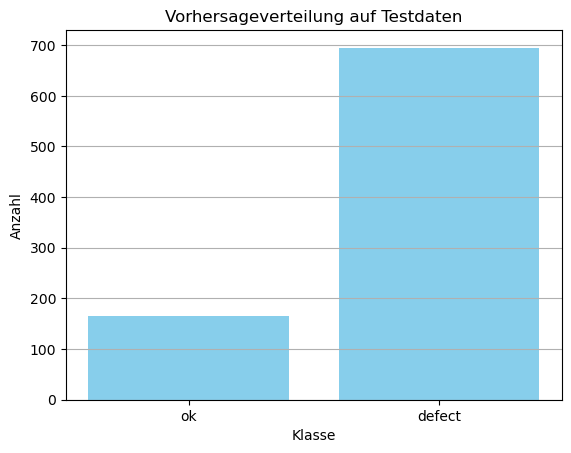

In [16]:
# --- Vorhersage für Testdaten ---
y_pred_test = clf_weighted.predict(X_test)

# Einzelne Vorhersagen anzeigen
print("\n--- Einzelne Vorhersagen für Testdaten ---")
for i, (true_label, predicted_label) in enumerate(zip(y_test, y_pred_test)):
    print(f"Bild {i+1}: ECHT = {true_label} | VORHERSAGE = {predicted_label}")

# Optional: Visualisierung als Balkendiagramm der Gesamtverteilung
from collections import Counter
import matplotlib.pyplot as plt

counter = Counter(y_pred_test)
plt.bar(counter.keys(), counter.values(), color='skyblue')
plt.title("Vorhersageverteilung auf Testdaten")
plt.ylabel("Anzahl")
plt.xlabel("Klasse")
plt.grid(axis='y')
plt.show()
